<div align="center">
    <img src="../figures/agu_banner.png" width="600"> <br> <br>
    <img src="../figures/bsu.png" width="100">
    <img src="../figures/eri.png" width="200"> 
    <img src="../figures/nasa.png" width="100"> 
</div>

# Convolutional Neural Network Tutorial for Image Regression.

    by: Joel A. Gongora
    Data Scientist, PhD Candidate, and Machine Learning Enthusiast
    
    Company: Elder Research Inc.
    Univ: Boise State University
    Dept: Geosciences
    
    email: joel.gongora@elderresearch.com

    This notebook was funded by Elder Research Inc., NASA's Earth and Space Science Fellowship, and Boise State University. It is intended for training purposes and case study of CNN's applied to spatial regression problems.

# Modules and Packages Needed
<div align="center">
    <img src="../figures/matplotlib.png" width="200"> &emsp;
    <img src="../figures/numpy.png" width="150"> &emsp;
    <img src="../figures/scipy.png" width="50"> &emsp;
    <img src="../figures/scikit-learn.png" width="150"> <br>
    <img src="../figures/tensorflow.png" width="150"> &emsp;
    <img src="../figures/keras.png" width="150"> 
    <img src="../figures/pandas_logo.png" width="250">      
</div>
   

* **numpy**: A powerful python package containing low-level tools designed to handle N-dimensional array objects, integrate C/C++/Fortran code, and can handle large linear algebra operations.
* **sys**: This module allows us to access basic, but very useful, variables, functions and tools of the python interpreter.
* **matplotlib**: Python 2D plotting library
* **mpl_toolkits** Collection of toolkits to ease the display of multiple images in matplotlib.
* **scipy**: Packages containing mathematics, science, and engineering specific tools.
* **sklearn**: Higher level tools needed for data mining and data analysis; under the hood is numpy, scipy, and matplotlib.
* **tensorflow**: An end-to-end platform for machine learning. 
* **keras**: A high level programing package designed for deep learning. 

# Import the Modules

In [1]:
from os.path import abspath
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import medfilt2d
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import model_from_json

### Import user defined functions
Here we use the function module **sys** and the function **abspath** to append our local path to the system paths so that I can find our functions located in: `../utils/utils.py`

In [2]:
for arch in ['../utils/']:
    if abspath(arch) not in sys.path:
        sys.path.append(abspath(arch))
        
from utils import (
    load_zipped_pickle
    ,df_to_array
    ,scale_data
    ,model_assessor
    ,plot_features
    ,plot_perturb_ex
    ,plot_ex_pred_vs_observed
    ,plot_outputs
    ,windowing_tool
    ,plot_output_feature
    ,feature_importance
)

### Size of Data Arrays and Sites to be Studied
Define the size of the arrays to be imported and the sites we will be using for the build of the CNN

In [3]:
NCOLS = 1099
NROWS = 1099
sitenames = ['buffalo_pass','spring_creek']

### Load the pickled datasets using the function defined in:
`./utils/utils.py`

Read pickled Pandas DataFrame containing the preprocessed data; here we make use of *F strings*.

In [4]:
data = {}  # create and empty dictionary
for site in sitenames:
    fname = f'../data/processed/{site}_subset.pickle'
    data[site] = load_zipped_pickle(abspath(fname))

Convert the DataFrame into Numpy Arrays as the `Tensorflow.Keras` package will expect `numpy` arrays as inputs to the **CNN model**.

Here we make use of the function `df_to_array` inputs for this function are the following:

```
    datos - (dataframe) 
    NROWS - (int) numer of rows in array: X
    NCOLS - (int) number of columns in the array: X
    coords - (list strings) column names of the coordinates
    omit -- (list strings) columns in data frame to omit from the features
    output - (list strings) column name of the target [Y]
```

Outpus for this function are:

```
    X -- (np.array, dim=[NROWS x NCOLS x no_features])
    Y -- (np.array [NROWS x NCOLS x no_outputs])
    UTME -- (np.array [NROWS x NCOLS])
    UTMN -- (np.array [NROWS x NCOLS]) 
    features - (list strings) names of the features w.r.t the arrays
```

In [5]:
coords = ['UTME', 'UTMN']
omit = []
output = ['snow_on']

# --------------------------------------------- #
# Instantiate Dictionaries to Store Site Arrays #
# --------------------------------------------- #

X = {}
Y = {}
UTME = {}
UTMN = {}
features = {}

# ------------------------- #
# Iterate through each site #
# ------------------------- #

for site, datos in data.items():
    datos.loc[datos['snow_on'] < 0, 'snow_on'] = 0
    X[site], Y[site], UTME[site], UTMN[site], features[site] = df_to_array(
        datos=datos
        ,NROWS=NROWS
        ,NCOLS=NCOLS
        ,coords=coords
        ,omit=omit
        ,output=output
    )

#### Print Inputs and Outputs

Here we iterate through the features and print the inputs and output we will be predicting. 

In [6]:
site = 'buffalo_pass'
print('Inputs: \t Output:')
print('--------\t--------')
for ix, f in enumerate(features[site]):
    if ix == 0:
        print(f,'\t',output[0])
    else:
        print(f)


Inputs: 	 Output:
--------	--------
snow_off 	 snow_on
raw_off
veg_h
tbreak_45
slope
aspect


#### Plot the Input Features
* Apply median filter

#### Learn how to generate multiple plots consistantly using <a href="https://matplotlib.org/3.1.1/tutorials/introductory/customizing.html"> mplstyle.</a> 

### Plot Outputs without Median Filtering

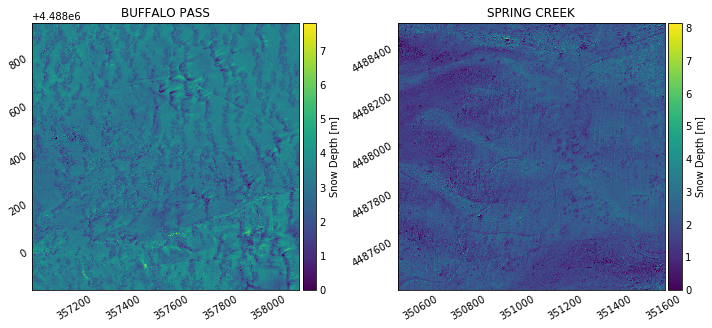

In [7]:
plot_outputs(
    data=data
    ,site=site
    ,UTME=UTME
    ,UTMN=UTMN
    ,Y=Y
    ,med_filt=False
    ,kernel_size=0
)

### Plot Outputs with Median Filter

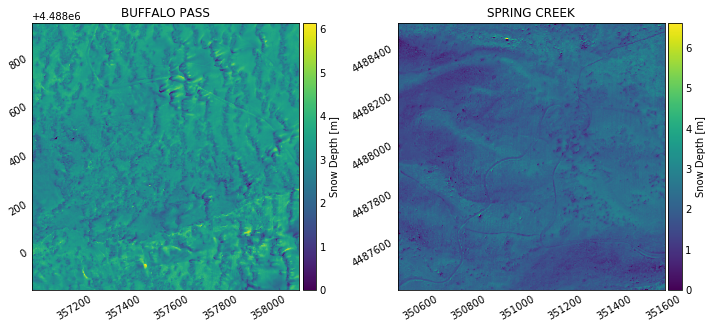

In [8]:
plot_outputs(
    data=data
    ,site=site
    ,UTME=UTME
    ,UTMN=UTMN
    ,Y=Y
    ,med_filt=True
    ,kernel_size=5
)

### Windowing Arrays to Generate Sample Images
<div align="left">
    <img src="../figures/buffalo_pass_windowed.png" width="500">
</div>
Calulate the number of sample images we will produce by windowing the data. 

### Window the Numpy Arrays
Define size of Kernel we would like to use to generate windows.

In [9]:
site = 'spring_creek'
input_shape = (30, 30)
input_stride = (30, 30)
padding = (0, 0)
size_of_window = X[site].shape[0] - input_shape[0] + 2 * padding[0]

number_of_windows = np.int(
    np.multiply(
        *np.floor(
            np.divide(
                np.subtract(
                    X[site].shape[:2], input_shape
                ), input_stride
            ) + 1
        )
    )
)

print(
    f'Number of Windows: {number_of_windows:d}'
)

Number of Windows: 1296


In [10]:
dict_of_windowed_arrays = {'X':X, 'Y':Y, 'UTME':UTME, 'UTMN':UTMN}

In [11]:
for key, value in dict_of_windowed_arrays.items():
    for site, dato in value.items():
        dict_of_windowed_arrays[key][site] = windowing_tool(
            signal=dato
            ,kernel_size=input_shape
            ,stride=input_stride
        )

Let's check to make sure we have the correct number of arrays

In [12]:
for site in dict_of_windowed_arrays['X'].keys():
    site = " ".join([s.upper() for s in site.split('_')])
    print(
        f"{site}: No. of Windows Created: {len(dict_of_windowed_arrays['X']['buffalo_pass'])}"
    )
    print(
        f"{site}: No. of Windows Expected: {number_of_windows}"
    )
    print('')

BUFFALO PASS: No. of Windows Created: 1296
BUFFALO PASS: No. of Windows Expected: 1296

SPRING CREEK: No. of Windows Created: 1296
SPRING CREEK: No. of Windows Expected: 1296



## Stack the list into a single numpy array of shape
#### (number_of_windows, input_shape[0], input_shape[1], number_of_features)

In [13]:
stacked_arrays = {}

In [14]:
for key, value in dict_of_windowed_arrays.items():
    stacked_arrays[key] = {}
    for llave, valor in value.items():
        stacked_arrays[key][llave] = np.stack(valor, axis=0)

### Print the shape of the Stacked Arrays

In [15]:
print("Input Shapes: ", stacked_arrays['X']['buffalo_pass'].shape)
print("Output Shape: ", stacked_arrays['Y']['buffalo_pass'].shape)

print("Features: ", features['buffalo_pass'])

Input Shapes:  (1296, 30, 30, 6)
Output Shape:  (1296, 30, 30, 1)
Features:  ['snow_off', 'raw_off', 'veg_h', 'tbreak_45', 'slope', 'aspect']


# Plot a Sample Image and a Single Feature

In [16]:
no_feat = 3
site = 'spring_creek'
img_index = 0

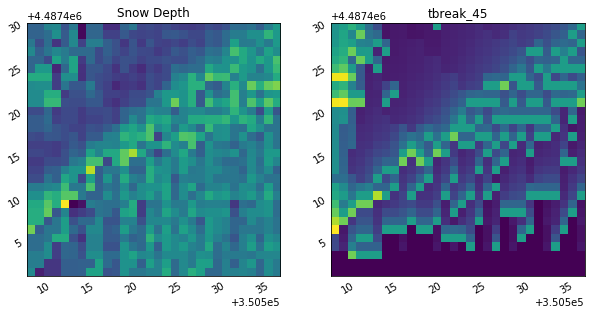

In [17]:
plot_output_feature(
    site=site
    ,img_index=0
    ,features=features
    ,no_feat=no_feat
    ,stacked_arrays=stacked_arrays
)

## Generate Train and Test Set
### Create a Dictionary to Save the Stacked Arrays

In [18]:
scaled_train_test = {}

for key, value in stacked_arrays.items():
    scaled_train_test[key] = {}

## Prep for CNN
1. Partition into train and test sets
2. Normalize training set
3. Normalize test set with training set statistics


In [19]:
seed = 99

for ix, site in enumerate(['buffalo_pass','spring_creek']):
    scaled_train_test['X'][site] \
    ,scaled_train_test['Y'][site] \
    ,scaled_train_test['UTME'][site] \
    ,scaled_train_test['UTMN'][site] = scale_data(
        X=stacked_arrays['X'][site]
        ,Y=stacked_arrays['Y'][site]
        ,UTME=stacked_arrays['UTME'][site]
        ,UTMN=stacked_arrays['UTMN'][site]
        ,train_per=0.80
        ,seed=seed
    )

### Setting Aside a Validation set for the Training of the Model

Let's randomly select a subset of images from the train set to use for validation

In [20]:
no_validation = 50
val_index = np.random.choice(
    scaled_train_test['X'][site]['train'].shape[0], no_validation, replace=False
) 

### Print the Shapes of the TRAIN, VALIDATION, and TEST sets

In [21]:
print(
    'train: ' + str(
        np.delete(
            scaled_train_test['X'][site]['train'], val_index, axis=0
        ).shape
    )
)
    
print(
    'validation: ' + str(
        scaled_train_test['X'][site]['train'][val_index,:,:,:].shape
    )
)
    
print(
    'test: ' + str(
        scaled_train_test['X'][site]['test'].shape
    )
)

train: (987, 30, 30, 6)
validation: (50, 30, 30, 6)
test: (259, 30, 30, 6)


### Let's Build the CNN Model:
    
<div align="center">
    <img src="../figures/resnet_cnnblock.png" width="950"> <br>
</div>

### Residual Block

<div align="center">
    '<img src="../figures/resnet_resblock.png" width="400">
</div>


In [22]:
def base_model(input_dim):
    input_layer = tf.keras.layers.Input(input_dim)

    # -------------- #
    #   CNN Block    #
    # -------------- #  
    
    conv_x = tf.keras.layers.Conv2D(filters=25, kernel_size=10, padding='same')(input_layer)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=5, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)

    # -------------- #
    # Residual Block #
    # -------------- #    
    
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(input_layer)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_1 = tf.keras.layers.Activation('relu')(conv_x)

    output_2 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='same')(output_1)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_2)
    
    model.compile(
        loss=tf.keras.losses.mean_squared_error
        ,optimizer=tf.keras.optimizers.Adam(lr=0.0001)
        ,metrics=['mse']
    )
    
    return model

In [62]:
epochs = 100
site = 'spring_creek'

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss'
    ,mode='min'
    ,verbose=1
    ,patience=10
)

# --------------------------- #
# Save the Best Model Weights #
# --------------------------- #

model_save = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(f'../models/best_model_{site}.h5')
    ,monitor='val_loss'
    ,verbose=0
    ,save_best_only=True
    ,save_weights_only=True
    ,mode='min'
)

model = base_model(
    np.delete(
        scaled_train_test['X'][site]['train']
        ,val_index
        ,axis=0
    ).shape[1:]
)

hist = model.fit(
    x=np.delete(
        scaled_train_test['X'][site]['train']
        ,val_index
        ,axis=0
    )
    ,y=np.delete(
        scaled_train_test['Y'][site]['train']
        ,val_index
        ,axis=0
    )
    ,epochs=epochs
    ,validation_data=(
        scaled_train_test['X'][site]['train'][val_index,:,:,:]
        ,scaled_train_test['Y'][site]['train'][val_index,:,:,:]
    )
)

# --------------------------- #
# Save the Model Architecture #
# --------------------------- #

model_json = model.to_json()
with open(
    os.path.join(f'../models/best_model_{site}.json'), 
    "w"
) as json_file:
    json_file.write(model_json)

Train on 987 samples, validate on 50 samples
Epoch 1/100
987/987 [==============================] - 13s 13ms/sample - loss: 1.3215 - mean_squared_error: 1.3215 - val_loss: 0.8189 - val_mean_squared_error: 0.8189
Epoch 2/100
987/987 [==============================] - 12s 12ms/sample - loss: 0.7990 - mean_squared_error: 0.7990 - val_loss: 0.7079 - val_mean_squared_error: 0.7079
Epoch 3/100
987/987 [==============================] - 12s 12ms/sample - loss: 0.6853 - mean_squared_error: 0.6853 - val_loss: 0.6570 - val_mean_squared_error: 0.6570
Epoch 4/100
987/987 [==============================] - 12s 12ms/sample - loss: 0.6098 - mean_squared_error: 0.6098 - val_loss: 0.5616 - val_mean_squared_error: 0.5616
Epoch 5/100
987/987 [==============================] - 12s 12ms/sample - loss: 0.5620 - mean_squared_error: 0.5620 - val_loss: 0.5392 - val_mean_squared_error: 0.5392
Epoch 6/100
987/987 [==============================] - 12s 13ms/sample - loss: 0.5183 - mean_squared_error: 0.5183 - val

### Plot the Learning Curves of the Training of the Model

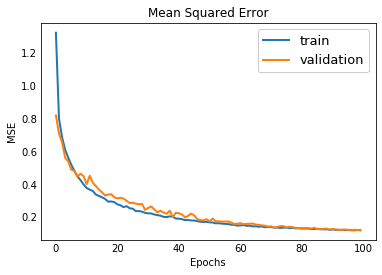

In [69]:
plt.style.use(
    '../plotstyles/nolatex_smallfont.mplstyle'
)
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='validation')
plt.legend()
plt.title('Mean Squared Error', fontsize=12)
plt.ylabel('MSE')
plt.xlabel('Epochs');

In [22]:
# load json and create model
json_file = open(
    os.path.join('../models/', f'best_model_{site}.json'), 
    'r'
)
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(
    os.path.join('../models/', f'best_model_{site}.h5')
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Lets make a Prediction on a Single Image

Recall the number of Train and Test Sets:

```
train: (987, 30, 30, 6)
validation: (50, 30, 30, 6)
test: (259, 30, 30, 6)
```

In [23]:
# index_to_predict = 200   # G
# index_to_predict = 65   # G
index_to_predict = 256   # G

train_or_test = 'test'

prediction_img = loaded_model.predict(
    np.expand_dims(scaled_train_test['X'][site][train_or_test][index_to_predict], axis=0)
).squeeze(axis=0).squeeze(axis=-1)

## Plot the Prediction vs Observed

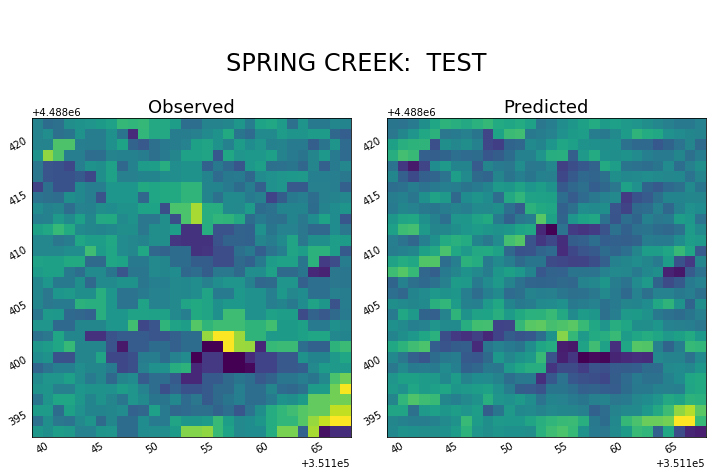

In [24]:
plot_ex_pred_vs_observed(
    scaled_train_test=scaled_train_test
    ,prediction_img=prediction_img
    ,index_to_predict=index_to_predict
    ,site=site
    ,train_or_test=train_or_test
)

### Input Shuffling for Feature Importance

In [25]:
perturb_feature = 'tbreak_45'

# ---------------------------- #
# Get the Index of the Feature #
# ---------------------------- #

f_idx = [
    i for i, v in enumerate(features[site]) if v == perturb_feature
][0]

In [26]:
import copy
permuted_train_test = copy.deepcopy(scaled_train_test)

# --------------------------- #
# Iterate over the Variables  #
# --------------------------- # 
for variable, var_dict in permuted_train_test.items():
    if variable not in ['UTME', 'UTMN', 'Y']:
        # ----------------------- #
        # Iterate over the Sites  #
        # ----------------------- #        
        for site_name, site_dict in var_dict.items():
            # ----------------------- #
            # Iterate over the Images #
            # ----------------------- #
            print(site_name)
            for tr_or_test in site_dict.keys():
                for img_idx in np.arange(
                    permuted_train_test[variable][site_name][tr_or_test].shape[0]
                ):
                    # ----------------------- #
                    # Permute the Feature     #
                    # ----------------------- #
                    np.apply_along_axis(
                        np.random.shuffle
                        ,axis=-1
                        ,arr=permuted_train_test[variable][site_name][tr_or_test][img_idx,:,:,f_idx]
                    )

buffalo_pass
spring_creek


In [27]:
permuted_prediction_img = loaded_model.predict(
    np.expand_dims(permuted_train_test['X'][site][train_or_test][index_to_predict], axis=0)
).squeeze(axis=0).squeeze(axis=-1)

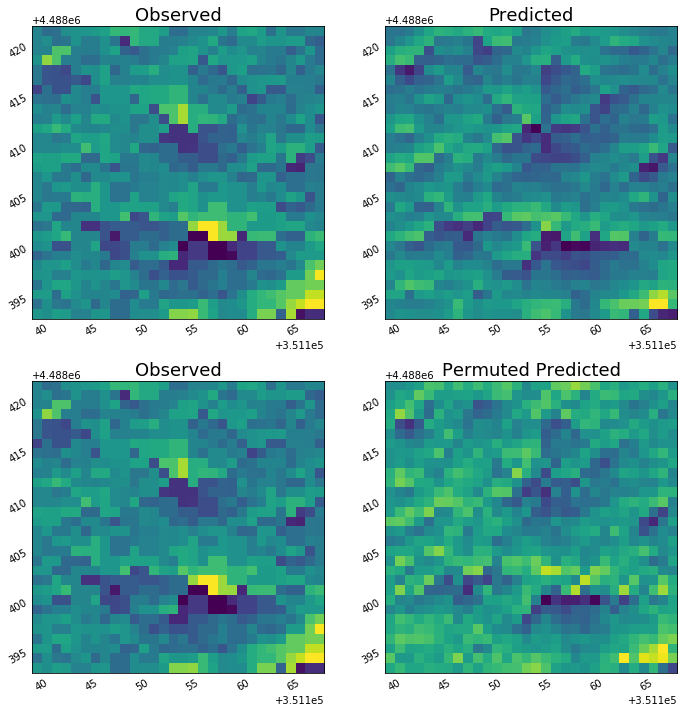

In [28]:
plot_perturb_ex(
    permuted_prediction_img=permuted_prediction_img
    ,prediction_img=prediction_img
    ,scaled_train_test=scaled_train_test
    ,permuted_train_test=permuted_train_test
    ,index_to_predict=index_to_predict
    ,site=site
    ,train_or_test=train_or_test
)

### Pre Permutation Accuracies

In [29]:
model_assessment = model_assessor(
    X=scaled_train_test['X'][site],
    Y=scaled_train_test['Y'][site],
    loaded_model=loaded_model,
    val_index=val_index
)

model_assessment

,R^2,RMSE,MAE,Pearson
train,0.528479,0.354953,0.275887,0.770731
val,0.439363,0.349547,0.269816,0.703653
test,0.537888,0.363655,0.280811,0.772994


### Post Permutation Accuracies

In [30]:
model_assessment_per = model_assessor(
    X=permuted_train_test['X'][site],
    Y=permuted_train_test['Y'][site],
    loaded_model=loaded_model,
    val_index=val_index
)

model_assessment_per

,R^2,RMSE,MAE,Pearson
train,0.425706,0.391731,0.302717,0.711823
val,0.340332,0.379164,0.292143,0.642480
test,0.434660,0.402227,0.307940,0.713978


### Differences Betweeen Permuted and Non-Permuted

In [31]:
feat_importance = feature_importance(
    scaled_train_test=scaled_train_test
    ,model=loaded_model
    ,features=features
    ,site=site
    ,val_index=val_index
)[['R^2', 'Pearson','RMSE', 'MAE']]

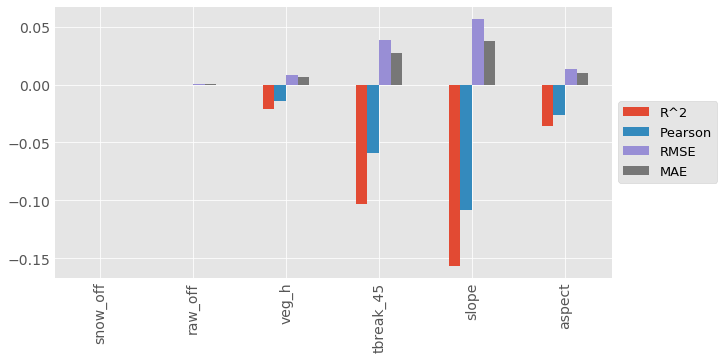

In [32]:
plt.style.use('ggplot')
plt.style.use('../plotstyles/nolatex_largefont.mplstyle')
f = plt.figure(figsize=(10,5))
feat_importance.plot(kind='bar', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()